### We First load the dataset and set the parameters to the model. For this experiment we are using RF.

In [3]:

###################################################
#               Parameter Setting                #
###################################################

fraction= 0.5 # how much of that database you want to use
frac_normal = .2 #how much of the normal classification you want to reduce
split = 0.70 # how you want to split the train/test data (this is percentage fro train)

#Model Parameters
max_depth = 5
n_estimators = 5
min_samples_split = 2

# XAI Samples
samples = 1 #5000

#Generate Explanations ?

explanator = True

# Specify the name of the output text file
output_file_name = "RF_SHAP_SML.txt"
with open(output_file_name, "w") as f: print('---------------------------------------------------------------------------------', file = f)

###################################################
###################################################
###################################################


print('--------------------------------------------------')
print('RF')
print('--------------------------------------------------')
print('Importing Libraries')
print('--------------------------------------------------')

# Makes sure we see all columns

from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.datasets import load_iris
# Loading Scikits random fo
#rest classifier
import sklearn
#import lime
from sklearn.preprocessing import OneHotEncoder

from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#from sklearn.metrics import auc_score
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter
from sklearn.preprocessing import label_binarize
#loading pandas
import pandas as pd
#Loading numpy
import numpy as np
# Setting random seed
import time

import shap
from scipy.special import softmax
np.random.seed(0)
import matplotlib.pyplot as plt
import random

from sklearn.metrics import f1_score, accuracy_score
#from interpret.blackbox import LimeTabular
from interpret import show
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

from lime_stability.stability import LimeTabularExplainerOvr
import lime

pd.set_option('display.max_columns', None)
shap.initjs()

print('Defining Function')
print('--------------------------------------------------')

def oversample(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='minority')
    # Convert to numpy and oversample
    x_np = X_train.to_numpy()
    y_np = y_train.to_numpy()
    x_np, y_np = oversample.fit_resample(x_np, y_np)
    
    # Convert back to pandas
    x_over = pd.DataFrame(x_np, columns=X_train.columns)
    y_over = pd.Series(y_np)
    return x_over, y_over
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the feature
s, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

def ACC(x,y,w,z):
    Acc = (x+y)/(x+w+z+y)
    return Acc

def PRECISION(x,w):
    Precision = x/(x+w)
    return Precision
def RECALL(x,z):
    Recall = x/(x+z)
    return Recall
def F1(Recall, Precision):
    F1 = 2 * Recall * Precision / (Recall + Precision)
    return F1
def BACC(x,y,w,z):
    BACC =(x/(x+z)+ y/(y+w))*0.5
    return BACC
def MCC(x,y,w,z):
    MCC = (y*x-z*w)/(((x+w)*(x+z)*(y+w)*(y+z))**.5)
    return MCC
def AUC_ROC(y_test_bin,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_avg = 0
    counting = 0
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     # plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
      #print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))
        auc_avg += auc(fpr[i], tpr[i])
        counting = i+1
    return auc_avg/counting
def oversample(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='minority')
    # Convert to numpy and oversample
    x_np = X_train.to_numpy()
    y_np = y_train.to_numpy()
    x_np, y_np = oversample.fit_resample(x_np, y_np)

    # Convert back to pandas
    x_over = pd.DataFrame(x_np, columns=X_train.columns)
    y_over = pd.Series(y_np)
    return x_over, y_over




print('Selecting Column Features')
print('--------------------------------------------------')


'''
########################################### SIMARGL Features ########################################
'''

# Select which feature method you want to use by uncommenting it.

'''
all features
'''

req_cols = ['FLOW_DURATION_MILLISECONDS','FIRST_SWITCHED',
            'TOTAL_FLOWS_EXP','TCP_WIN_MSS_IN','LAST_SWITCHED',
            'TCP_WIN_MAX_IN','TCP_WIN_MIN_IN','TCP_WIN_MIN_OUT',
           'PROTOCOL','TCP_WIN_MAX_OUT','TCP_FLAGS',
            'TCP_WIN_SCALE_OUT','TCP_WIN_SCALE_IN','SRC_TOS',
            'DST_TOS','FLOW_ID','L4_SRC_PORT','L4_DST_PORT',
           'MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','TOTAL_PKTS_EXP',
           'TOTAL_BYTES_EXP','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS',
            'ALERT']





--------------------------------------------------
RF
--------------------------------------------------
Importing Libraries
--------------------------------------------------


/N/u/oarreche/BigRed200/anaconda3/envs/HITL/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defining Function
--------------------------------------------------
Selecting Column Features
--------------------------------------------------


In [4]:

print('Loading Database')
print('--------------------------------------------------')

#Denial of Service
df0 = pd.read_csv ('sensor_db/dos-03-15-2022-15-44-32.csv', usecols=req_cols)
df1 = pd.read_csv ('sensor_db/dos-03-16-2022-13-45-18.csv', usecols=req_cols)
df2 = pd.read_csv ('sensor_db/dos-03-17-2022-16-22-53.csv', usecols=req_cols)
df3 = pd.read_csv ('sensor_db/dos-03-18-2022-19-27-05.csv', usecols=req_cols)
df4 = pd.read_csv ('sensor_db/dos-03-19-2022-20-01-53.csv', usecols=req_cols)
df5 = pd.read_csv ('sensor_db/dos-03-20-2022-14-27-54.csv', usecols=req_cols)

#Normal
df7 = pd.read_csv  ('sensor_db/normal-03-15-2022-15-43-44.csv', usecols=req_cols)
df8 = pd.read_csv  ('sensor_db/normal-03-16-2022-13-44-27.csv', usecols=req_cols)
df9 = pd.read_csv  ('sensor_db/normal-03-17-2022-16-21-30.csv', usecols=req_cols)
df10 = pd.read_csv ('sensor_db/normal-03-18-2022-19-17-31.csv', usecols=req_cols)
df11 = pd.read_csv ('sensor_db/normal-03-18-2022-19-25-48.csv', usecols=req_cols)
df12 = pd.read_csv ('sensor_db/normal-03-19-2022-20-01-16.csv', usecols=req_cols)
df13 = pd.read_csv ('sensor_db/normal-03-20-2022-14-27-30.csv', usecols=req_cols)

#PortScanning
df14 = pd.read_csv  ('sensor_db/portscanning-03-15-2022-15-44-06.csv', usecols=req_cols)
df15 = pd.read_csv  ('sensor_db/portscanning-03-16-2022-13-44-50.csv', usecols=req_cols)
df16 = pd.read_csv  ('sensor_db/portscanning-03-17-2022-16-22-53.csv', usecols=req_cols)
df17 = pd.read_csv  ('sensor_db/portscanning-03-18-2022-19-27-05.csv', usecols=req_cols)
df18 = pd.read_csv  ('sensor_db/portscanning-03-19-2022-20-01-45.csv', usecols=req_cols)
df19 = pd.read_csv  ('sensor_db/portscanning-03-20-2022-14-27-49.csv', usecols=req_cols)

frames = [df0, df1, df2, df3, df4, df5, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19]

#concat data frames
df = pd.concat(frames,ignore_index=True)

# shuffle the DataFrame rows
df = df.sample(frac = fraction)

# assign alert column to y
y = df.pop('ALERT')

# join alert back to df
df = df.assign( ALERT = y) 

#Fill NaN with 0s
df = df.fillna(0)

#df.pop('PROTOCOL_MAP')

print('---------------------------------------------------------------------------------')
print('Removing top features')
print('---------------------------------------------------------------------------------')
print('')






# df.pop('TCP_WIN_MAX_IN')
# df.pop('TCP_WIN_SCALE_IN')
# df.pop('TCP_WIN_MSS_IN')
# df.pop('TCP_WIN_MIN_IN')
# df.pop('OUT_PKTS')
# df.pop('FLOW_DURATION_MILLISECONDS')
# df.pop('IN_PKTS')
# df.pop('L4_DST_PORT')
# df.pop('LAST_SWITCHED')
# df.pop('TCP_WIN_MIN_OUT')
# df.pop('TCP_FLAGS')
# df.pop('TOTAL_FLOWS_EXP')
# df.pop('FLOW_ID')
# df.pop('TCP_WIN_MAX_OUT')
# df.pop('SRC_TOS')
# df.pop('TCP_WIN_SCALE_OUT')
# df.pop('FIRST_SWITCHED')
# df.pop('L4_SRC_PORT')
# df.pop('PROTOCOL')
# df.pop('DST_TOS')
# df.pop('MIN_IP_PKT_LEN')
# df.pop('MAX_IP_PKT_LEN')
# df.pop('TOTAL_PKTS_EXP')
# df.pop('TOTAL_BYTES_EXP')
# df.pop('IN_BYTES')
# df.pop('OUT_BYTES')


print('---------------------------------------------------------------------------------')
print('Reducing Normal rows')
print('---------------------------------------------------------------------------------')
print('')


#filters

filtered_normal = df[df['ALERT'] == 'None']

#reduce

reduced_normal = filtered_normal.sample(frac=frac_normal)

#join

df = pd.concat([df[df['ALERT'] != 'None'], reduced_normal])

''' ---------------------------------------------------------------'''

# Normalize database
print('---------------------------------------------------------------------------------')
print('Normalizing database')
print('---------------------------------------------------------------------------------')
print('')

# make a df copy
df_max_scaled = df.copy()

# assign alert column to y
y = df_max_scaled.pop('ALERT')

#Normalize operation
for col in df_max_scaled.columns:
    t = abs(df_max_scaled[col].max())
    df_max_scaled[col] = df_max_scaled[col]/t
df_max_scaled
#assign df copy to df
df = df_max_scaled.assign( ALERT = y)
#Fill NaN with 0s
df = df.fillna(0)

# Separate features and labels
y = df.pop('ALERT')
X = df

print('---------------------------------------------------------------------------------')
print('Balance Datasets')
print('---------------------------------------------------------------------------------')
print('')

counter = Counter(y)
print(counter)

# call balance operation until all labels have the same size
counter_list = list(counter.values())
for i in range(1,len(counter_list)):
    if counter_list[i-1] != counter_list[i]:
        df, y = oversample(df, y)

counter = Counter(y)


df = df.assign(ALERT = y)
print('train len',counter)

y = df.pop('ALERT')
X = df

df = df.assign(ALERT = y)
# ## Train and Test split

print('---------------------------------------------------------------------------------')
print('Separating Training and Testing db')
print('---------------------------------------------------------------------------------')
print('')

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, train_size=split)
df = X.assign( ALERT = y)

# Balance Dataset

print('---------------------------------------------------------------------------------')
print('Balance Datasets')
print('---------------------------------------------------------------------------------')
print('')
counter = Counter(labels_train)
print(counter)
'''
# call balance operation until all labels have the same size
counter_list = list(counter.values())
for i in range(1,len(counter_list)):
    if counter_list[i-1] != counter_list[i]:
        train, labels_train = oversample(train, labels_train)


counter = Counter(labels_train)
print(counter)

'''

Loading Database
--------------------------------------------------
---------------------------------------------------------------------------------
Removing top features
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------
Reducing Normal rows
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------
Normalizing database
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------
Balance Datasets
---------------------------------------------------------------------------------

Counter({'Denial of Service': 3214209, 'Port Scanning': 2085315, 'None': 1954864})
train len Counter({'Port Scanning': 3214209, 'Denial of Service': 3214209, 'None': 3214209})
---------------

'\n# call balance operation until all labels have the same size\ncounter_list = list(counter.values())\nfor i in range(1,len(counter_list)):\n    if counter_list[i-1] != counter_list[i]:\n        train, labels_train = oversample(train, labels_train)\n\n\ncounter = Counter(labels_train)\nprint(counter)\n\n'

### Now we train the model

In [5]:


# # After OverSampling training dataset

train = train.assign( ALERT = labels_train)

#Drop ALert column from train
train.pop('ALERT')
# ## Training the model
u, label = pd.factorize(labels_train)

print('Defining the model')
print('--------------------------------------------------')
rf = RandomForestClassifier(max_depth = max_depth,  n_estimators = n_estimators, min_samples_split = min_samples_split, n_jobs = -1)
#------------------------------------------------------------------------------

print('Training the model')
print('------------------------------------------------------------------------------')
#START TIMER MODEL
start = time.time()
model = rf.fit(train, labels_train)
#END TIMER MODEL
end = time.time()
print('ELAPSE TIME MODEL: ',(end - start)/60, 'min')

print('------------------------------------------------------------------------------')
#------------------------------------------------------------------------------
# # Oversampling and balancing test data
counter = Counter(labels_test)
print(counter)
counter_list = list(counter.values())
'''
for i in range(1,len(counter_list)):
    if counter_list[i-1] != counter_list[i]:
        test, labels_test = oversample(test, labels_test)

'''
counter = Counter(labels_test)

#joining features and label
test = test.assign(ALERT = labels_test)

#Randomize df order
test = test.sample(frac = 1)

#Drop label column
labels_test = test.pop('ALERT')

#------------------------------------------------------------------------------
#START TIMER PREDICTION
start = time.time()
preds = rf.predict(test)
#END TIMER PREDICTION
end = time.time()
print('ELAPSE TIME PREDICTION: ',(end - start)/60, 'min')

print('------------------------------------------------------------------------------')
#------------------------------------------------------------------------------
pred_label = preds
confusion_matrix = pd.crosstab(labels_test,  pred_label , rownames=['Actual ALERT'], colnames = ['Predicted ALERT'])
with open(output_file_name, "a") as f: print(confusion_matrix, file = f)

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)

TP_total = sum(TP)
TN_total = sum(TN)
FP_total = sum(FP)
FN_total = sum(FN)

TP_total = np.array(TP_total,dtype=np.float64)
TN_total = np.array(TN_total,dtype=np.float64)
FP_total = np.array(FP_total,dtype=np.float64)
FN_total = np.array(FN_total,dtype=np.float64)

Acc = ACC(TP_total,TN_total, FP_total, FN_total)
Precision = PRECISION(TP_total, FP_total)
Recall = RECALL(TP_total, FN_total)
F1 = F1(Recall,Precision)
BACC = BACC(TP_total,TN_total, FP_total, FN_total)
MCC = MCC(TP_total,TN_total, FP_total, FN_total)

with open(output_file_name, "a") as f: print('Accuracy: ', Acc, file =f)
print('Accuracy: ')
print('Precision: ', Precision )
print('Recall: ', Recall )
print('F1: ', F1 )
print('BACC: ', BACC)
print('MCC: ', MCC)
for i in range(0,len(TP)):
    Acc = ACC(TP[i],TN[i], FP[i], FN[i])
    print('Accuracy: ', label[i] ,' - ' , Acc)
y_test = labels_test
y_score = rf.predict_proba(test)
#binarize the output
y_test_bin = label_binarize(y_test,classes = [0,1,2])
n_classes = y_test_bin.shape[1]
tmp, y_labels = pd.factorize(labels_test)
label = y_labels
print('AUC_ROC total: ', roc_auc_score(labels_test, rf.predict_proba(test), multi_class='ovr'))




Defining the model
--------------------------------------------------
Training the model
------------------------------------------------------------------------------
ELAPSE TIME MODEL:  0.4601336677869161 min
------------------------------------------------------------------------------
Counter({'None': 964668, 'Denial of Service': 964406, 'Port Scanning': 963715})
ELAPSE TIME PREDICTION:  0.012361514568328857 min
------------------------------------------------------------------------------
Accuracy: 
Precision:  0.996004893547369
Recall:  0.996004893547369
F1:  0.996004893547369
BACC:  0.9970036701605267
MCC:  0.9940073403210536
Accuracy:  Denial of Service  -  0.9982055379773637
Accuracy:  Port Scanning  -  0.996004893547369
Accuracy:  None  -  0.9977993555700053
AUC_ROC total:  0.9997673449330233


## From here on, we are going to analyze the Completeness of SHAP

##                        DoS SAMPLE

### Here we pick one DoS sample from the test dataset and generate an explanation as it is

In [71]:
#filters
row = 1
test = test.assign(ALERT = labels_test)
# print(label)
# print(test)
Dos_samples = test[test['ALERT'] == 'Denial of Service']
# print(Dos_samples)
Dos_sample = Dos_samples[row:row+1]
Dos_y = Dos_samples.pop('ALERT')
Dos_sample.pop('ALERT')
test.pop('ALERT')



1428661    Denial of Service
6753594                 None
5017486    Denial of Service
9550894        Port Scanning
318414     Denial of Service
                 ...        
308869         Port Scanning
4415478        Port Scanning
1677515    Denial of Service
1073106        Port Scanning
1620972    Denial of Service
Name: ALERT, Length: 2892789, dtype: object

['Denial of Service', 'None', 'Port Scanning']
The RF predicted: Denial of Service
------------------------------------------
Actual value Denial of Service
------------------------------------------
---------------------------------------------------------------------------------
TCP_WIN_SCALE_IN               0.23955919286252844            0.5                           
TCP_WIN_MAX_IN                 0.22742207134877232            0.9802395666437781            
TCP_WIN_MIN_IN                 0.11335295370940898            0.9802395666437781            
OUT_PKTS                       0.028500052397289276           0.0                           
TCP_FLAGS                      0.018176683553245945           0.008298755186721992          
TCP_WIN_MAX_OUT                0.016674776816598767           0.0                           
TCP_WIN_MIN_OUT                0.016373434882863205           0.0                           
L4_DST_PORT                    0.0017054059219857958          0.006

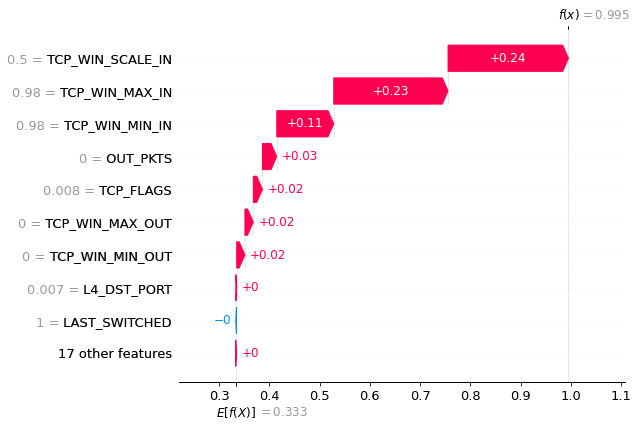

In [72]:
label = list(label) 
print(label)
explainer = shap.TreeExplainer(rf)
start_index = 0
end_index = samples
 # datapoint to explain
prediction = rf.predict(Dos_sample)[0] # Prediction of the sample
print(f"The RF predicted: {prediction}")
print("------------------------------------------")
print( 'Actual value', 'Denial of Service')
print("------------------------------------------")
#extract the index accordingly to prediction
# print(prediction)
index = label.index(prediction)

# print(index)
#generating shap values explainer
sv = explainer(Dos_sample) 
bv = explainer.expected_value[index]
exp = shap.Explanation(sv[:,:,index], sv.base_values[:,index], test[start_index:end_index], feature_names=test.columns.tolist())
# generating plot
shap.waterfall_plot(exp[0],max_display=10,show= None)
# plt.savefig('RF_Shap_Waterfall.png')
# plt.clf()
# shap_values = explainer.shap_values(test[start_index:end_index])
# vals= np.abs(shap_values).mean(1)



# feature_importance = pd.DataFrame(list(zip(Normal_sample.columns, sum(vals))), columns=['col_name','feature_importance_vals'])

feature_importance = pd.DataFrame({
    'row_id': Dos_sample.index.values.repeat(Dos_sample.shape[1]),
    'feature': Dos_sample.columns.to_list() * Dos_sample.shape[0],
    'feature_value': Dos_sample.values.flatten(),
    'base_value': bv,
    'shap_values': sv.values[:,:,index].flatten()
   
})

feature_importance['shap_values'] = abs(feature_importance['shap_values'])

# print(feature_importance)
# feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.sort_values(by=['shap_values'], ascending=False,inplace=True)
feature_importance.head()
# print(feature_importance.to_string())

print('---------------------------------------------------------------------------------')
# feature_importance_vals = 'feature_importance_vals'  # Replace with the name of the column you want to extract
shap_val = feature_importance['shap_values'].tolist()
feature_val = feature_importance['feature_value'].tolist()
feature_name = feature_importance['feature'].tolist()
# col_name = 'col_name'  # Replace with the name of the column you want to extract
# feature_name = feature_importance['col_name'].tolist()




for item1, item2, item3 in zip(feature_name, shap_val, feature_val):
    print("{:<30} {:<30} {:<30}".format(item1, item2, item3))

# DoS - Perturbing features

### Here we are changing the top feature to see if can change its classification

In [73]:

Dos_sample['TCP_WIN_SCALE_IN'] = 0
# Dos_sample['TCP_WIN_MAX_IN'] = 0
# Dos_sample['OUT_PKTS'] = 1
# Dos_sample['TCP_WIN_MIN_IN'] = 1
# Dos_sample['TCP_FLAGS'] = 1

The RF predicted: Denial of Service
------------------------------------------
Actual value Denial of Service
------------------------------------------
---------------------------------------------------------------------------------


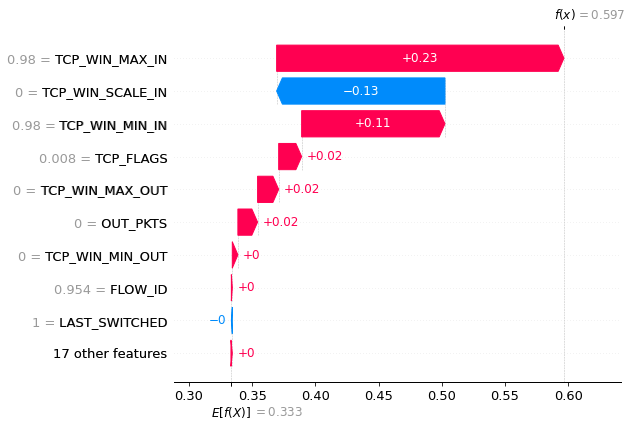

In [74]:

 # datapoint to explain
prediction = rf.predict(Dos_sample)[0] # Prediction of the sample
print(f"The RF predicted: {prediction}")
print("------------------------------------------")
print( 'Actual value', 'Denial of Service')
print("------------------------------------------")
#extract the index accordingly to prediction
# print(prediction)
index = label.index(prediction)
# print(index)
#generating shap values explainer
sv = explainer(Dos_sample) 
bv = explainer.expected_value[1]
exp = shap.Explanation(sv[:,:,index], sv.base_values[:,index], Dos_sample, feature_names=test.columns.tolist())
# generating plot
shap.waterfall_plot(exp[0],max_display=10,show= None)
# plt.savefig('RF_Shap_Waterfall.png')
# plt.clf()
# shap_values = explainer.shap_values(test[start_index:end_index])
# vals= np.abs(shap_values).mean(1)



# feature_importance = pd.DataFrame(list(zip(Normal_sample.columns, sum(vals))), columns=['col_name','feature_importance_vals'])

feature_importance = pd.DataFrame({
    'row_id': Dos_sample.index.values.repeat(Dos_sample.shape[1]),
    'feature': Dos_sample.columns.to_list() * Dos_sample.shape[0],
    'feature_value': Dos_sample.values.flatten(),
    'base_value': bv,
    'shap_values': sv.values[:,:,index].flatten()
   
})

feature_importance['shap_values'] = abs(feature_importance['shap_values'])

feature_importance.sort_values(by=['shap_values'], ascending=False,inplace=True)
feature_importance.head()
print('---------------------------------------------------------------------------------')
# feature_importance_vals = 'feature_importance_vals'  # Replace with the name of the column you want to extract
shap_val = feature_importance['shap_values'].tolist()
feature_val = feature_importance['feature_value'].tolist()
feature_name = feature_importance['feature'].tolist()
# for item1, item2, item3 in zip(feature_name, shap_val, feature_val):
#     print("{:<30} {:<30} {:<30}".format(item1, item2, item3))

### As we can see the class did not change, but the feature we perturbed (TCP_WIN_SCALE_IN) is pushing the classification to not DoS. This feature is a strong candidate for explanation! Let's perturbe the second top feature and see what happens

In [75]:

Dos_sample['TCP_WIN_SCALE_IN'] = 0
Dos_sample['TCP_WIN_MAX_IN'] = 0
# Dos_sample['OUT_PKTS'] = 1
# Dos_sample['TCP_WIN_MIN_IN'] = 1
# Dos_sample['TCP_FLAGS'] = 1

The RF predicted: None
------------------------------------------
Actual value Denial of Service
------------------------------------------
---------------------------------------------------------------------------------


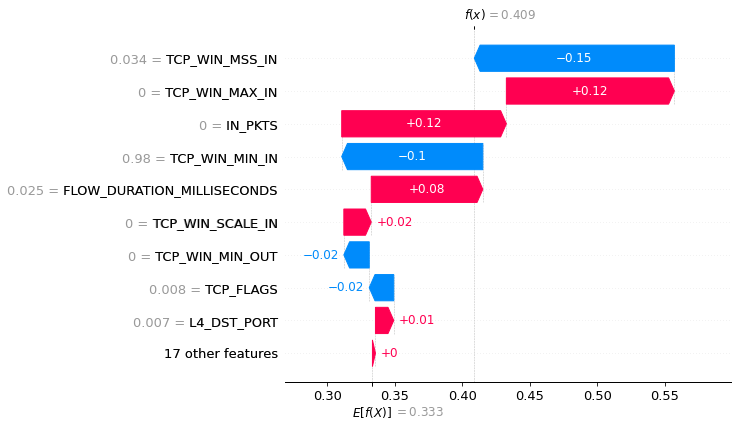

In [76]:

 # datapoint to explain
prediction = rf.predict(Dos_sample)[0] # Prediction of the sample
print(f"The RF predicted: {prediction}")
print("------------------------------------------")
print( 'Actual value', 'Denial of Service')
print("------------------------------------------")
#extract the index accordingly to prediction
# print(prediction)
index = label.index(prediction)
# print(index)
#generating shap values explainer
sv = explainer(Dos_sample) 
bv = explainer.expected_value[1]
exp = shap.Explanation(sv[:,:,index], sv.base_values[:,index], Dos_sample, feature_names=test.columns.tolist())
# generating plot
shap.waterfall_plot(exp[0],max_display=10,show= None)
# plt.savefig('RF_Shap_Waterfall.png')
# plt.clf()
# shap_values = explainer.shap_values(test[start_index:end_index])
# vals= np.abs(shap_values).mean(1)



# feature_importance = pd.DataFrame(list(zip(Normal_sample.columns, sum(vals))), columns=['col_name','feature_importance_vals'])

feature_importance = pd.DataFrame({
    'row_id': Dos_sample.index.values.repeat(Dos_sample.shape[1]),
    'feature': Dos_sample.columns.to_list() * Dos_sample.shape[0],
    'feature_value': Dos_sample.values.flatten(),
    'base_value': bv,
    'shap_values': sv.values[:,:,index].flatten()
   
})

feature_importance['shap_values'] = abs(feature_importance['shap_values'])

feature_importance.sort_values(by=['shap_values'], ascending=False,inplace=True)
feature_importance.head()
print('---------------------------------------------------------------------------------')
# feature_importance_vals = 'feature_importance_vals'  # Replace with the name of the column you want to extract
shap_val = feature_importance['shap_values'].tolist()
feature_val = feature_importance['feature_value'].tolist()
feature_name = feature_importance['feature'].tolist()
# for item1, item2, item3 in zip(feature_name, shap_val, feature_val):
#     print("{:<30} {:<30} {:<30}".format(item1, item2, item3))

### Now we see that the class has changed to None. The feature we perturbed is still pushing to be DoS, but it is importance decreased, which also makes this feature a good canditate for explanation. Therefore this experiment is Complete for Shap

# Normal Sample

In [77]:
#filters
row = 3
test = test.assign(ALERT = labels_test)

# print(test)
Normal_samples = test[test['ALERT'] == 'None']
Normal_sample = Normal_samples[row:row+1]
Normal_y = Normal_samples.pop('ALERT')
Normal_sample.pop('ALERT')
test.pop('ALERT')
# Normal_samples.pop("ALERT")

1428661    Denial of Service
6753594                 None
5017486    Denial of Service
9550894        Port Scanning
318414     Denial of Service
                 ...        
308869         Port Scanning
4415478        Port Scanning
1677515    Denial of Service
1073106        Port Scanning
1620972    Denial of Service
Name: ALERT, Length: 2892789, dtype: object

The RF predicted: None
------------------------------------------
Actual value None
------------------------------------------
---------------------------------------------------------------------------------


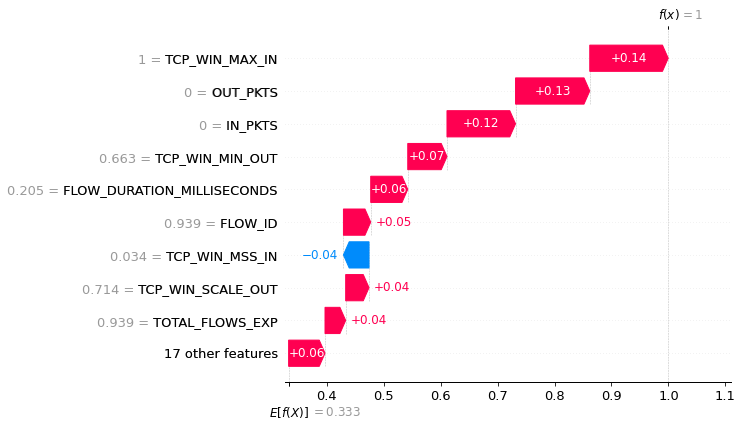

In [78]:
label = list(label) 
# print(label)
explainer = shap.TreeExplainer(rf)
start_index = 0
end_index = samples
 # datapoint to explain
prediction = rf.predict(Normal_sample)[0] # Prediction of the sample
print(f"The RF predicted: {prediction}")
print("------------------------------------------")
print( 'Actual value', 'None')
print("------------------------------------------")
#extract the index accordingly to prediction
# print(prediction)
index = label.index(prediction)
# print(index)
#generating shap values explainer
sv = explainer(Normal_sample) 
bv = explainer.expected_value[1]
exp = shap.Explanation(sv[:,:,index], sv.base_values[:,index], test[start_index:end_index], feature_names=test.columns.tolist())
# generating plot
shap.waterfall_plot(exp[0],max_display=10,show= None)
# plt.savefig('RF_Shap_Waterfall.png')
# plt.clf()
# shap_values = explainer.shap_values(test[start_index:end_index])
# vals= np.abs(shap_values).mean(1)



# feature_importance = pd.DataFrame(list(zip(Normal_sample.columns, sum(vals))), columns=['col_name','feature_importance_vals'])

feature_importance = pd.DataFrame({
    'row_id': Normal_sample.index.values.repeat(Normal_sample.shape[1]),
    'feature': Normal_sample.columns.to_list() * Normal_sample.shape[0],
    'feature_value': Normal_sample.values.flatten(),
    'base_value': bv,
    'shap_values': sv.values[:,:,index].flatten()
   
})

feature_importance['shap_values'] = abs(feature_importance['shap_values'])

# print(feature_importance)
# feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.sort_values(by=['shap_values'], ascending=False,inplace=True)
feature_importance.head()
# print(feature_importance.to_string())

print('---------------------------------------------------------------------------------')
# feature_importance_vals = 'feature_importance_vals'  # Replace with the name of the column you want to extract
shap_val = feature_importance['shap_values'].tolist()
feature_val = feature_importance['feature_value'].tolist()
feature_name = feature_importance['feature'].tolist()
# col_name = 'col_name'  # Replace with the name of the column you want to extract
# feature_name = feature_importance['col_name'].tolist()




# for item1, item2, item3 in zip(feature_name, shap_val, feature_val):
#     print("{:<30} {:<30} {:<30}".format(item1, item2, item3))

# Perturbating the Normal sample

### We see here that we can play with the perturbation values as much as we will not be able to change the class of the feature. This means this explanation is degenerated and not valid. Therefore not complete

In [79]:
Normal_sample['TCP_WIN_MAX_IN'] = 0.5
Normal_sample['OUT_PKTS'] = 0.5
Normal_sample['IN_PKTS'] = 0.5
Normal_sample['TCP_WIN_MIN_OUT'] = 0.2
Normal_sample['FLOW_DURATION_MILLISECONDS'] = 0.5

The RF predicted: None
------------------------------------------
Actual value None
------------------------------------------
---------------------------------------------------------------------------------


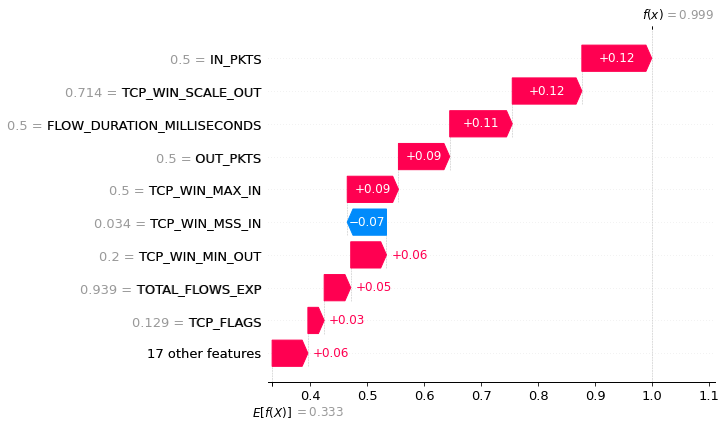

In [80]:

 # datapoint to explain
prediction = rf.predict(Normal_sample)[0] # Prediction of the sample
print(f"The RF predicted: {prediction}")
print("------------------------------------------")
print( 'Actual value', 'None')
print("------------------------------------------")
#extract the index accordingly to prediction
# print(prediction)
index = label.index(prediction)
# print(index)
#generating shap values explainer
sv = explainer(Normal_sample) 
bv = explainer.expected_value[index]
exp = shap.Explanation(sv[:,:,index], sv.base_values[:,index], Normal_sample, feature_names=test.columns.tolist())
# generating plot
shap.waterfall_plot(exp[0],max_display=10,show= None)
# plt.savefig('RF_Shap_Waterfall.png')
# plt.clf()
# shap_values = explainer.shap_values(test[start_index:end_index])
# vals= np.abs(shap_values).mean(1)



# feature_importance = pd.DataFrame(list(zip(Normal_sample.columns, sum(vals))), columns=['col_name','feature_importance_vals'])

feature_importance = pd.DataFrame({
    'row_id': Normal_sample.index.values.repeat(Normal_sample.shape[1]),
    'feature': Normal_sample.columns.to_list() * Normal_sample.shape[0],
    'feature_value': Normal_sample.values.flatten(),
    'base_value': bv,
    'shap_values': sv.values[:,:,index].flatten()
   
})

feature_importance['shap_values'] = abs(feature_importance['shap_values'])

feature_importance.sort_values(by=['shap_values'], ascending=False,inplace=True)
feature_importance.head()
print('---------------------------------------------------------------------------------')
# feature_importance_vals = 'feature_importance_vals'  # Replace with the name of the column you want to extract
shap_val = feature_importance['shap_values'].tolist()
feature_val = feature_importance['feature_value'].tolist()
feature_name = feature_importance['feature'].tolist()
# for item1, item2, item3 in zip(feature_name, shap_val, feature_val):
#     print("{:<30} {:<30} {:<30}".format(item1, item2, item3))

# Generalization

### Next let's see how many samples are suscetible and not susceptible to perturbations

### To simplify our code, we create two functions Waterfall_explanator and completeness_all. The first contains the code to generate SHAP waterfall plots and the other will run the perturbation analysis for n samples

In [11]:
import warnings
warnings.filterwarnings("ignore")
label = list(label)

In [13]:
#Define function to test sample with the waterfall plot
def waterfall_explanator(sample):
    # datapoint to explain
    explainer = shap.TreeExplainer(rf)
    prediction = rf.predict(sample)[0] # Prediction of the sample
    #extract the index accordingly to prediction
    index = label.index(prediction)
    #generating shap values explainer
    sv = explainer(sample) 
    bv = explainer.expected_value[index]
    exp = shap.Explanation(sv[:,:,index], sv.base_values[:,index], sample, feature_names=test.columns.tolist())
    # generating plot
    # shap.waterfall_plot(exp[0],max_display=10,show= None)
    # plt.savefig('RF_Shap_Waterfall.png')
    # plt.clf()

    feature_importance = pd.DataFrame({
        'row_id': sample.index.values.repeat(sample.shape[1]),
        'feature': sample.columns.to_list() * sample.shape[0],
        'feature_value': sample.values.flatten(),
        'base_value': bv,
        'shap_values': sv.values[:,:,index].flatten()
    
    })

    feature_importance['shap_values'] = abs(feature_importance['shap_values'])
    feature_importance.sort_values(by=['shap_values'], ascending=False,inplace=True)
    feature_importance.head()
    shap_val = feature_importance['shap_values'].tolist()
    feature_val = feature_importance['feature_value'].tolist()
    feature_name = feature_importance['feature'].tolist()
    
    return (prediction, shap_val,feature_val,feature_name)

In [8]:
def completeness_all(single_class_samples,number_samples, number_of_features_pertubation):
    Counter_all_samples = 0
    counter_samples_changed_class = 0
    print('------------------------------------------------')
    print('Initiating Completeness Experiment')
    print('------------------------------------------------')
    for i in range(0,number_samples):
        #select sample
        try:
            sample = single_class_samples[i:i+1]
        except:
            break # break if there more samples requested than samples in the dataset
        # Explanate the original sample
        u = waterfall_explanator(sample)
        #select top 5 features from the original sample
        top_k_features = []
        top_k_features.append(u[3][0]) #append first feature
        break_condition = False
        for k in range(1,number_of_features_pertubation):
            for j in range(11):  # 11 steps to include 1.0 (0 to 10)
                perturbation = j / 10.0  # Divide by 10 to get steps of 0.1
                temp_var = sample[top_k_features[k-1]]
                sample[top_k_features[k-1]] = perturbation
                v = waterfall_explanator(sample)
                if v[0] != u[0]: 
                    break_condition = True
                    counter_samples_changed_class += 1                   
                    break
                else: sample[top_k_features[k-1]] = abs(temp_var - 1) # set the sample feature value as the symetric opposite
            top_k_features.append(u[3][k]) #append second, third feature .. and so on
            if break_condition == True: break
        Counter_all_samples += 1
        progress  = 100*Counter_all_samples/number_samples
        if progress%10 == 0: print('Progress', progress ,'%')
    # print('Number of Normal samples that changed classification: ',counter_samples_changed_class)
    # print('Number of all samples analyzed: ',Counter_all_samples)
    return(counter_samples_changed_class,Counter_all_samples)
        

### Here we filter the test data set for the label Denial of Service

In [84]:

test = test.assign(ALERT = labels_test)
Dos_samples = test[test['ALERT'] == 'Denial of Service']
# print(Dos_samples)
Dos_y = Dos_samples.pop('ALERT')
test.pop('ALERT')


1428661    Denial of Service
6753594                 None
5017486    Denial of Service
9550894        Port Scanning
318414     Denial of Service
                 ...        
308869         Port Scanning
4415478        Port Scanning
1677515    Denial of Service
1073106        Port Scanning
1620972    Denial of Service
Name: ALERT, Length: 2892789, dtype: object

### Now we set up how many samples we want to run the completeness experiments, and how many top features we want to perturbe.

In [85]:
num_samples = 1000
num_feat_pertubation = 5

p = completeness_all(Dos_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of DoS samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')

------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------


Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %
Progress 50.0 %
Progress 60.0 %
Progress 70.0 %
Progress 80.0 %
Progress 90.0 %
Progress 100.0 %
(1000, 1000)
Number of DoS samples that changed classification:  1000
Number of all samples analyzed:  1000
100.0 % - samples are complete 


### Completeness for Normal 

In [9]:
test = test.assign(ALERT = labels_test)
Normal_samples = test[test['ALERT'] == 'None']
Normal_y = Normal_samples.pop('ALERT')
test.pop('ALERT')

1428661    Denial of Service
6753594                 None
5017486    Denial of Service
9550894        Port Scanning
318414     Denial of Service
                 ...        
308869         Port Scanning
4415478        Port Scanning
1677515    Denial of Service
1073106        Port Scanning
1620972    Denial of Service
Name: ALERT, Length: 2892789, dtype: object

In [14]:
num_samples = 1000
num_feat_pertubation = 5

p = completeness_all(Normal_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of Normal samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')

------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------
Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %


### Completeness for Port Scanning

In [ ]:
test = test.assign(ALERT = labels_test)
PS_samples = test[test['ALERT'] == 'Port Scanning']
PS_y = PS_samples.pop('ALERT')
test.pop('ALERT')

1428661    Denial of Service
6753594                 None
5017486    Denial of Service
9550894        Port Scanning
318414     Denial of Service
                 ...        
308869         Port Scanning
4415478        Port Scanning
1677515    Denial of Service
1073106        Port Scanning
1620972    Denial of Service
Name: ALERT, Length: 2892789, dtype: object

In [ ]:
num_samples = 1000
num_feat_pertubation = 5

p = completeness_all(PS_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of PS samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')

------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------
Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %
Progress 50.0 %
Progress 60.0 %
Progress 70.0 %
Progress 80.0 %
Progress 90.0 %
Progress 100.0 %
(10, 10)
Number of PS samples that changed classification:  10
Number of all samples analyzed:  10
